In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils, localizer


2024-02-08 21:51:12.098664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 21:51:12.098720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 21:51:12.101137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 21:51:12.110815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 21:51:13.467375: W tensorflow/compiler/tf2

In [2]:
# model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')
# model_ew.save('models/ew_localizer.hdf5')


In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:50]}

In [4]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

ew_input_features = input_features_reduced#['Eccentricity', 'Semimajor Axis (m)', 'Argument of Periapsis (deg)', 'Longitude (deg)', 'Altitude (m)']
#ew_input_features = ['Eccentricity', 'Longitude (deg)', 'Latitude (deg)']

ns_input_features = input_features_reduced#['Eccentricity', 'Semimajor Axis (m)',  'Inclination (deg)', 'Latitude (deg)', 'Longitude (deg)']


utils.set_random_seed(42)
ds_gen_ew = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ew_input_features,
                                      with_labels=True, pad_location_labels=0,
                                      nonbinary_padding=[100.0, 70.0, 49.0, 34.0, 24.0],
                                      train_val_split=0.8,
                                      input_stride=2,
                                      padding='none',
                                      transform_features=True,
                                      scale=True,
                                      per_object_scaling=True,
                                      input_history_steps=48,
                                      input_future_steps=24, seed=181)

# ds_gen_ns = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ns_input_features,
#                                       with_labels=True, pad_location_labels=0,
#                                       nonbinary_padding=[100.0, 70.0, 49.0, 34.0, 24.0],
#                                       train_val_split=0.8, input_stride=2, padding='none',
#                                       transform_features=True,
#                                       scale=True,
#                                       per_object_scaling=True,
#                                       input_history_steps=48, input_future_steps=24, seed=181)

=========================Creating Generator=======================
Seed: 181
nTrain: 1520 nVal: 380 (0.80)
Padding: none
Scaling: True  (per-object)
Horizons: 48-24 @ stride 2
Sin-Transformed features: ['True Anomaly (deg)', 'Argument of Periapsis (deg)']
Padding node locations in non-binary fashion ([24.0, 34.0, 49.0, 70.0, 100.0, 70.0, 49.0, 34.0, 24.0])
=========================Finished Generator=======================


In [ ]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location'], shuffle=True, stride=1)

print(train_ew.element_spec)

#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,32],[32,16]], dense_layers=[64,32], l2_reg=0.0001, mixed_dropout=0.1, lr_scheduler=[30000,0.8], seed=0)
model_ew = prediction_models.Dense_NN(val_ew, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#model_ew = prediction_models.LSTM_NN(val_ew, input_dropout=0.0, mixed_dropout=0.1, lstm_layers=[128,64], dense_layers=[32,16], l2_reg=0.0001, lr_scheduler=[], seed=1)

train_ew = train_ew.map(lambda x,y:(x,y['EW_Node_Location']))
val_ew = val_ew.map(lambda x,y:(x,y['EW_Node_Location'])) # temporary fix to allow class weights

model_ew.summary()
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=20, verbose=1, plot_hist=True, 
                    class_weight={0: 1.0, 1: 2.0}, 
                    callbacks=[])
#model_ew.model.save('models/ew_localizer.hdf5')

2024-02-08 22:09:11.648735: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1699846560 exceeds 10% of free system memory.
2024-02-08 22:09:12.223765: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1699846560 exceeds 10% of free system memory.


Train-DS Cardinality: tf.Tensor(655805, shape=(), dtype=int64)
(TensorSpec(shape=(None, 36, 9), dtype=tf.float64, name=None), {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 9)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 28, 32)            2624      
                                                                 
 activation_2 (Activation)   (None, 28, 32)            0         
                                                                 
 dropout_4 (Dropout)         (None, 28, 32)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 23, 32)            6176      
                                                  

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


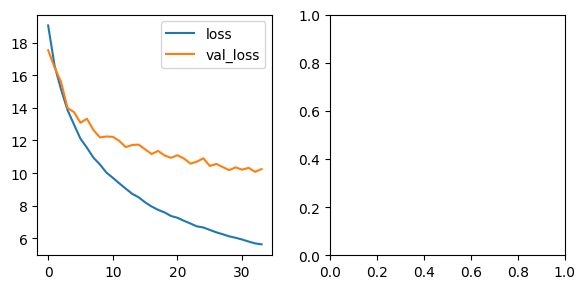

In [10]:
train_ew, val_ew = ds_gen_ew.get_datasets(512,
                                          label_features=['EW_Node_Location_nb'],
                                          shuffle=True,
                                          stride=1,
                                          keep_label_stride=5)
print(train_ew.element_spec)

model_ew = prediction_models.Dense_NN_regression(val_ew,
                                                 conv1d_layers=[[32,9],[32,6],[32,3]], 
                                                 dense_layers=[32,16],
                                                 l2_reg=0.000,
                                                 mixed_dropout_dense=0.35,
                                                 mixed_dropout_cnn=0.25,
                                                 lr_scheduler=[0.001,2500,0.9],
                                                 final_activation='linear',
                                                 seed=0)

model_ew.summary()
# TODO: seed and dropout have a very strong impact on wether the model is able to learn at all
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=35, verbose=1, plot_hist=True, callbacks=[])


In [20]:
train_ns, val_ns = ds_gen_ns.get_stateful_datasets(
                                          with_identifier=True,
                                          label_features=['NS_Node_Location_nb'],
                                          stride=1)
labels = np.stack([element for element in val_ns.map(lambda x,y,z:x).as_numpy_iterator()])
print(labels.shape)

(2099, 10, 36, 9)


In [21]:
print(labels[:10,3,:])

[[[-0.90872371  0.85068673 -1.1314069  ... -0.49037841 -2.55543613
    0.61731082]
  [ 1.18235946 -1.19698715 -1.11229634 ...  0.68367869 -2.55615449
   -0.13839838]
  [ 1.19499302 -1.18307495 -1.1126318  ...  1.14470673 -2.54886413
   -1.65268171]
  ...
  [ 1.18373358 -1.18674994 -0.57753617 ...  0.02417978 -2.31602192
   -2.25468993]
  [ 1.18562257 -1.1786629  -0.52756429 ... -0.53885853 -2.30328321
   -1.056903  ]
  [ 1.18379927 -1.19336569 -0.51668453 ... -0.5202204  -2.29975772
    0.33244982]]

 [[ 1.17375708 -1.1952033  -1.11958003 ...  0.1164585  -2.55640602
    0.41584584]
  [ 1.18886673 -1.19053543 -1.111269   ...  1.0608623  -2.55375791
   -0.89744878]
  [ 1.1974901  -1.18131924 -1.11093616 ...  0.90982389 -2.54181743
   -2.19300461]
  ...
  [ 1.18670988 -1.17998016 -0.55129772 ... -0.30463049 -2.30865908
   -1.78147459]
  [ 1.18375707 -1.18473732 -0.51627558 ... -0.61577553 -2.30038214
   -0.28104106]
  [ 1.18247783 -1.19606137 -0.51598972 ... -0.28599834 -2.30059314
    0.

In [6]:
train_ns, val_ns = ds_gen_ns.get_stateful_datasets(
                                          label_features=['NS_Node_Location_nb'],
                                          stride=1)
print(train_ns.element_spec)

model_ns = prediction_models.STATEFUL_LSTM(train_ns, val_ns,
                                            dense_layers=[32,16],
                                            lstm_layers=[48,48],
                                            l2_reg=0.000,
                                            mixed_dropout_dense=0.25,
                                            mixed_dropout_lstm=0.2,
                                            lr_scheduler=[0.002,7500,0.9],
                                            seed=0)

model_ns.summary()

(TensorSpec(shape=(None, 36, 9), dtype=tf.float64, name=None), {'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs_History (InputLayer  [(40, 36, 9)]             0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (40, 36, 48)              11136     
                                                                 
 dropout (Dropout)           (40, 36, 48)              0         
                                                                 
 lstm_2 (LSTM)               (40, 48)                  18624     
                                                                 
 dropout_1 (Dropout)         (40, 48)                  0         
                                                 

In [7]:
model_ns.load_weights('submission/models/ns_localizer_lstm.hdf5')

In [ ]:

hist = model_ns.fit(train_ns, val_ds=val_ns,
                    epochs=2,
                    eval_frequency=2,
                    verbose=1,
                    plot_hist=False)

2024-02-07 16:42:00.297602: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-07 16:42:00.323018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-07 16:42:00.323091: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-07 16:42:00.325784: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-07 16:42:00.325862: I external/local_xla/xla/stream_executor

(TensorSpec(shape=(None, 36, 9), dtype=tf.float64, name=None), {'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs_History (InputLayer  [(400, 36, 9)]            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (400, 36, 48)             11136     
                                                                 
 dropout (Dropout)           (400, 36, 48)             0         
                                                                 
 lstm_1 (LSTM)               (400, 48)                 18624     
                                                                 
 dropout_1 (Dropout)         (400, 48)                 0         
                                                 

2024-02-07 16:42:07.162787: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2176243200 exceeds 10% of free system memory.
2024-02-07 16:42:11.613296: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-07 16:42:13.030087: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff04c036a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-07 16:42:13.030158: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-07 16:42:13.035358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707320533.136346   30074 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2099/2099 [==============================] - 69s 30ms/step - loss: 15.4643 - mse: 15.4643 - mae: 0.4967
Epoch 0/2: Train:[15.4821/15.4821] Val:[15.8482/15.8482] (loss/mse)
2099/2099 [==============================] - 15s 7ms/step - loss: 15.8488 - mse: 15.8488 - mae: 0.4549
Finished Training after 2 epochs. Final Metrics:
Train:[15.4847/15.4847]Val:[15.8488/15.8488](loss/mse)


In [5]:
train_ns, val_ns = ds_gen_ns.get_datasets(512,
                                          label_features=['NS_Node_Location_nb'],
                                          shuffle=True,
                                          stride=1,
                                          keep_label_stride=5)
print(train_ns.element_spec)

2024-02-08 21:20:05.403981: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 21:20:05.426906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 21:20:05.426987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 21:20:05.428830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 21:20:05.428912: I external/local_xla/xla/stream_executor

Train-DS Cardinality: tf.Tensor(651313, shape=(), dtype=int64)
(TensorSpec(shape=(None, 36, 9), dtype=tf.float64, name=None), {'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 9)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 28, 32)            2624      
                                                                 
 activation_3 (Activation)   (None, 28, 32)            0         
                                                                 
 dropout_5 (Dropout)         (None, 28, 32)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 23, 32)            6176      
                                                                 
 activation_4 (Activation)   (None, 23, 32)            0         
                                                                 
 dropout_6 (Dropout)         (None, 23, 32)            0   

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


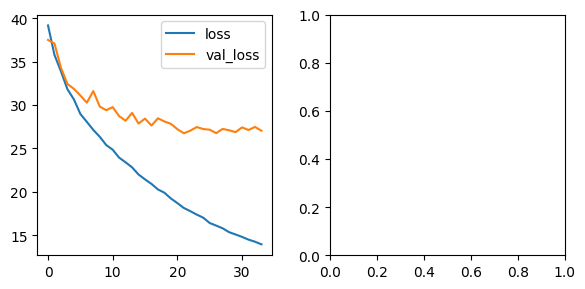

In [17]:


model_ns = prediction_models.Dense_NN_regression(val_ns,
                                                 conv1d_layers=[[32,9],[32,6],[32,3]], 
                                                 dense_layers=[32,16],
                                                 l2_reg=0.00,
                                                 mixed_dropout_dense=0.25,
                                                 mixed_dropout_cnn=0.2,
                                                 lr_scheduler=[0.002,2500,0.9],
                                                 final_activation='linear',
                                                 seed=0)

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=35, verbose=1, plot_hist=True, callbacks=[])


In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location_nb'], shuffle=True, stride=1)
model_ns = prediction_models.Dense_NN_regression(val_ns, conv1d_layers=[[32,6],[32,6]], dense_layers=[16,4],
                                                 l2_reg=0.0, mixed_dropout=0.2,
                                                 lr_scheduler=[0.002,15000,0.9],
                                                 final_activation='relu',
                                                 seed=0)
model_ns.load_model('submission/models/ns_localizer_cnn.hdf5')
model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=10, verbose=1, plot_hist=True, callbacks=[])

Starting training. Optimizing "val_accuracy"
Epoch 1/15


1273/1273 [==============================] - 18s 13ms/step - loss: 13.6725 - mse: 13.6725 - mae: 0.5776 - val_loss: 26.9447 - val_mse: 26.9447 - val_mae: 0.7765
Epoch 2/15
1273/1273 [==============================] - 17s 12ms/step - loss: 13.4433 - mse: 13.4433 - mae: 0.5706 - val_loss: 26.8626 - val_mse: 26.8626 - val_mae: 0.7927
Epoch 3/15
1273/1273 [==============================] - 17s 12ms/step - loss: 13.2316 - mse: 13.2316 - mae: 0.5613 - val_loss: 27.1330 - val_mse: 27.1330 - val_mae: 0.7821
Epoch 4/15
1273/1273 [==============================] - 17s 12ms/step - loss: 13.0807 - mse: 13.0807 - mae: 0.5564 - val_loss: 27.7263 - val_mse: 27.7263 - val_mae: 0.8105
Epoch 5/15
1273/1273 [==============================] - 17s 13ms/step - loss: 12.8289 - mse: 12.8289 - mae: 0.5495 - val_loss: 27.5206 - val_mse: 27.5206 - val_mae: 0.7805
Epoch 6/15
1273/1273 [==============================] - 18s 13ms/step - loss: 12.7018 - mse: 12.7018 - mae: 0.5457 - val_loss: 27.1698 - val_mse: 27.16

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


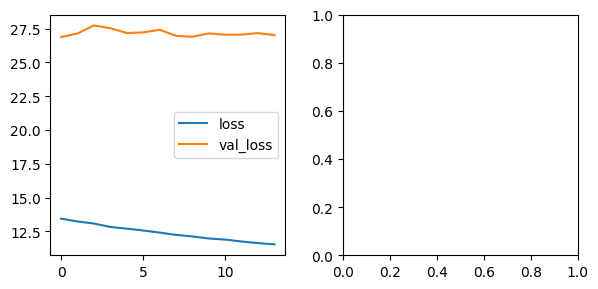

In [20]:
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=15, verbose=1, plot_hist=True, callbacks=[])

Starting training. Optimizing "val_accuracy"
Epoch 1/15


1457/1457 [==============================] - 16s 11ms/step - loss: 14.9844 - mse: 14.9844 - mae: 0.6995 - val_loss: 22.4718 - val_mse: 22.4718 - val_mae: 0.8080
Epoch 2/15
1457/1457 [==============================] - 16s 11ms/step - loss: 14.2061 - mse: 14.2061 - mae: 0.6673 - val_loss: 22.8046 - val_mse: 22.8046 - val_mae: 0.8053
Epoch 3/15
1457/1457 [==============================] - 16s 11ms/step - loss: 13.9608 - mse: 13.9608 - mae: 0.6504 - val_loss: 22.5457 - val_mse: 22.5457 - val_mae: 0.7990
Epoch 4/15
1457/1457 [==============================] - 16s 11ms/step - loss: 13.7055 - mse: 13.7055 - mae: 0.6419 - val_loss: 22.3976 - val_mse: 22.3976 - val_mae: 0.7857
Epoch 5/15
1457/1457 [==============================] - 16s 11ms/step - loss: 13.7655 - mse: 13.7655 - mae: 0.6407 - val_loss: 21.9821 - val_mse: 21.9821 - val_mae: 0.7616
Epoch 6/15
1457/1457 [==============================] - 16s 11ms/step - loss: 13.6081 - mse: 13.6081 - mae: 0.6385 - val_loss: 21.8776 - val_mse: 21.87

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


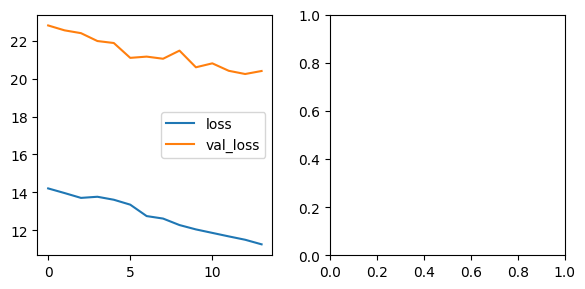

In [11]:
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=15, verbose=1, plot_hist=True, callbacks=[])

In [28]:
model_ns.model.save('submission/models/ns_localizer_cnn.hdf5')
#pickle.dump(ds_gen_ew.scaler, open('submission/models/EW_localizer_scaler_cnn.pkl', 'wb'))

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
model_ns.save_weights('submission/models/ns_localizer_lstm.hdf5')

In [16]:
print(model_ns.model.optimizer.learning_rate)

<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.0011809799>


In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location'], shuffle=True, stride=1)

model_ns = prediction_models.Dense_NN(train_ns, conv1d_layers=[], dense_layers=[256, 128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
train_ns = train_ns.map(lambda x,y:(x,y['NS_Node_Location']))
val_ns = val_ns.map(lambda x,y:(x,y['NS_Node_Location'])) # temporary fix to allow class weights

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=20, verbose=1, plot_hist=False, class_weight={0: 0.5, 1: 20.0}, callbacks=[])
model_ns.model.save('models/ns_localizer.hdf5')

model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [12]:
model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')


In [ ]:
model_ew = tf.keras.models.load_model('submission/models/ew_localizer_cnn.hdf5')


In [11]:
object_limit = None
direction = 'EW'

preds_df = localizer.create_prediction_df(ds_gen=ds_gen_ew,
                                model=model_ew,
                                train=False,
                                test=False,
                                stateful=False,
                                output_dirs=[direction],
                                object_limit=object_limit,
                                ds_batch_size=256,
                                prediction_batches=5,
                                verbose=1)

625/625 [==============================] - 2s 4ms/step


In [22]:
print(len(preds_df['NS_Loc'].unique()))

754336


In [16]:
subm_df = localizer.postprocess_predictions(preds_df=preds_df,
                                            dirs=[direction],
                                            threshold=70.0,
                                            add_initial_node=True,
                                            clean_consecutives=True)

evaluator, sub_df = localizer.evaluate_localizer(subm_df=subm_df,
                                                 gt_path=challenge_data_dir / 'train_labels.csv',
                                                 object_ids=list(map(int, ds_gen_ew.val_keys))[:object_limit],
                                                 dirs=[direction],
                                                 with_initial_node=False,
                                                 return_scores=False,
                                                 verbose=1)

# EW after 35 epochs:
# 50: TP: 592 FP: 52 FN: 59
# 55: TP: 591 FP: 40 FN: 60
# 60: TP: 590 FP: 35 FN: 61
# 65: TP: 585 FP: 29 FN: 66
# 70: TP: 579 FP: 22 FN: 72

# NS after 35 epochs:
# TODO: for NS, ID nodes are clearly the most difficult
# 50: TP: 293 FP: 95 FN: 136
# 55: TP: 288 FP: 77 FN: 141
# 60: TP: 280 FP: 53 FN: 149
# 65: TP: 274 FP: 45 FN: 155
# 70: TP: 268 FP: 33 FN: 161


Evaluator ignoring classifications
Precision: 0.96
Recall: 0.89
F2: 0.90
RMSE: 0.7388
TP: 579 FP: 22 FN: 72


In [ ]:
localizer.plot_prediction_curve(ds_gen=ds_gen_ew,
                                model=model_ew,
                                label_features=['EW_Node_Location_nb'],
                                object_ids=ds_gen_ew.val_keys[10:20],
                                zoom=True)